<a href="https://colab.research.google.com/github/adeleyeobalolu1/Traffic-Sign-Detection-Model/blob/main/Traffic_Sign_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# Import necessary libraries

import os
import cv2
import random
import shutil
import pickle
import numpy  as np
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [31]:
# Parameters

path = "/content/drive/MyDrive/Ai Projects/myData"
label_file = '/content/labels.csv'
batch_size_val = 50
steps_per_epoch_val = 2000
epochs_val = 10
image_dim = (32,32,3)
test_ratio = 0.2
val_ratio = 0.2

# **Import images and split data**

In [32]:
# Import Images

count = 0
images = []
classNo = []
myList = os.listdir(path)
no_of_classes = len(myList)
print('Total No of Classes Detected:', no_of_classes)
print('Importing Classes........')

for x in range(0, len(myList)):
    imgList = os.listdir(path+'//'+str(count))
    for y in imgList:
      cur_img = cv2.imread(path+'//'+str(count)+'//'+y)
      images.append(cur_img)
      classNo.append(count)
    print(count, end = ' ')
    count += 1
print(' ')

images = np.array(images)
classNo = np.array(classNo)




Total No of Classes Detected: 43
Importing Classes........
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [33]:
# Split Data to Train, val, and Test

X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size = test_ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_ratio)

In [34]:
# Checking Data Shapes

print("Data Shapes")

print(f"Train: {(X_train.shape, y_train.shape)}")
print(f"Validation: {(X_val.shape, y_val.shape)}")
print(f"Test: {(X_test.shape, y_test.shape)}")

assert(X_train.shape[0]==y_train.shape[0]), "Images and labels are not the same in train set"
assert(X_val.shape[0]==y_val.shape[0]), "Images and labels are not the same in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "Images and labels are not the same in test set"
assert(X_train.shape[1:] == (image_dim)), "Train Image dimensions are wrong"
assert(X_test.shape[1:] == (image_dim)), "Test Image dimensions are wrong"
assert(X_val.shape[1:] == (image_dim)), "Validation Image dimensions are wrong"

Data Shapes
Train: ((22271, 32, 32, 3), (22271,))
Validation: ((5568, 32, 32, 3), (5568,))
Test: ((6960, 32, 32, 3), (6960,))


In [35]:
# Read the labels
data = pd.read_csv(label_file)
print("Label data", data.shape,type(data))

Label data (43, 2) <class 'pandas.core.frame.DataFrame'>


[116, 1272, 1268, 806, 1129, 1046, 224, 846, 804, 842, 1157, 740, 1198, 1218, 444, 345, 223, 633, 708, 117, 191, 178, 212, 296, 154, 884, 326, 133, 313, 168, 270, 426, 130, 376, 231, 651, 224, 110, 1220, 178, 187, 144, 133]


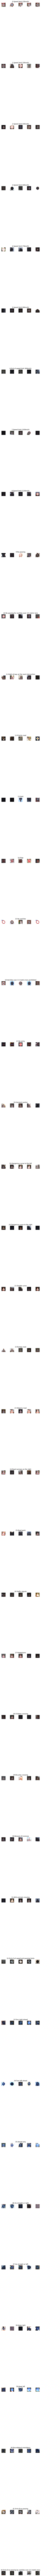

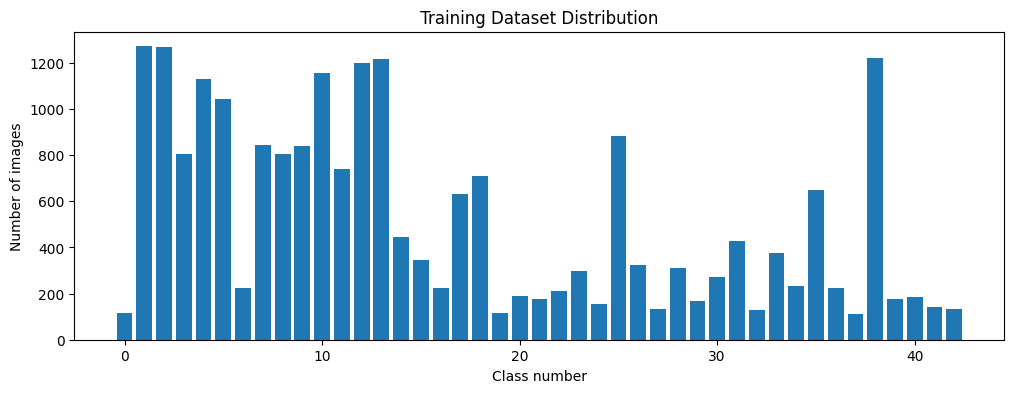

In [36]:
# Read Sample Images of all Classes
num_of_samples = []
cols = 5
num_classes = no_of_classes
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize = (5,300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,len(x_selected)-1),:,:], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i==2:
          axs[j][i].set_title(str(j)+ "-" + row["Name"])
          num_of_samples.append(len(x_selected))


# Data of the number of samples in each category
print(num_of_samples)
plt.figure(figsize = (12,4))
plt.bar(range(0,num_classes), num_of_samples)
plt.title(" Training Dataset Distribution ")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

# **Preprocessing**

In [37]:
# Preprocessing Images

def preprocessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img


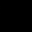

In [38]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))
img = cv2.imread("Grayscale", X_train[random.randint(0, len(X_train)-1)])
cv2_imshow(img)

In [39]:
# Adding a depth if 1

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


In [40]:
# Data Augmentation

dataGen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    shear_range = 0.1,
    rotation_range = 10
)

In [41]:
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

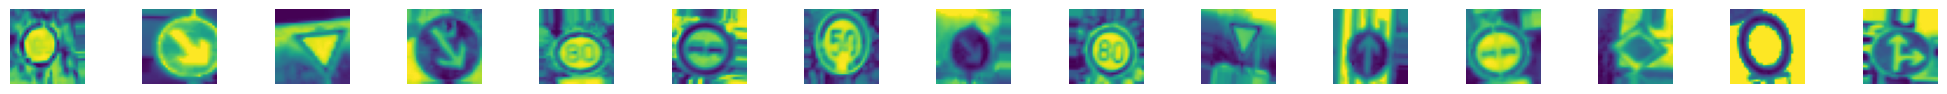

In [42]:
# Augmented sample
fig, axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(image_dim[0], image_dim[1]))
    axs[i].axis('off')

plt.show()

In [43]:
y_train = to_categorical(y_train, no_of_classes)
y_val = to_categorical(y_val, no_of_classes)
y_test = to_categorical(y_test, no_of_classes)

# **Model Building & Training**

In [44]:
filNo = 60
filSize1 = (5,5)

filSize2 = (3,3)
poolSize = (2,2)
node = 500

model = Sequential()
model.add((Conv2D(filNo, filSize1, input_shape = (image_dim[0], image_dim[1], 1), activation= 'relu')))
model.add((Conv2D(filNo, filSize1, activation= 'relu')))
model.add(MaxPooling2D(pool_size=poolSize))


model.add((Conv2D(filNo//2, filSize2, activation= 'relu')))
model.add((Conv2D(filNo //2, filSize2, activation= 'relu')))
model.add(MaxPooling2D(pool_size=poolSize))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(node, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(no_of_classes, activation='softmax'))


opt = Adam(learning_rate=0.001)
loss = 'categorical_crossentropy'
metric = ['accuracy']

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
model.compile(optimizer=opt, loss=loss, metrics=metric)

In [46]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = model.fit(
    dataGen.flow(X_train, y_train, batch_size= batch_size_val),
    steps_per_epoch= steps_per_epoch_val,
    epochs = epochs_val,
    validation_data = (X_val, y_val)
    )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 442/2000 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.9247 - loss: 0.2420

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9252 - loss: 0.2401 - val_accuracy: 0.9890 - val_loss: 0.0362
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9281 - loss: 0.2298 - val_accuracy: 0.9917 - val_loss: 0.0292
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9307 - loss: 0.2252 - val_accuracy: 0.9887 - val_loss: 0.0366
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9316 - loss: 0.2178 - val_accuracy: 0.9917 - val_loss: 0.0259
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9373 - loss: 0.2059 - val_accuracy: 0.9939 - val_loss: 0.0224
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9411 - loss: 0.1880 - val_accuracy: 0.9930 - val_loss: 0.0270
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9420 - loss: 0.1826 - val_accuracy: 0.9921 - val_loss: 0.0266
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9471 - loss: 0.1789 - val

# **Model Evaluation**

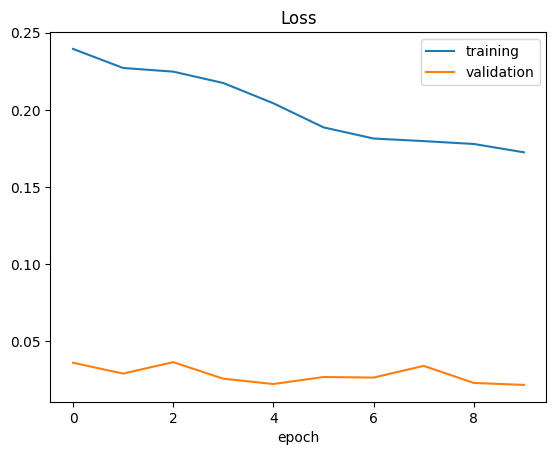

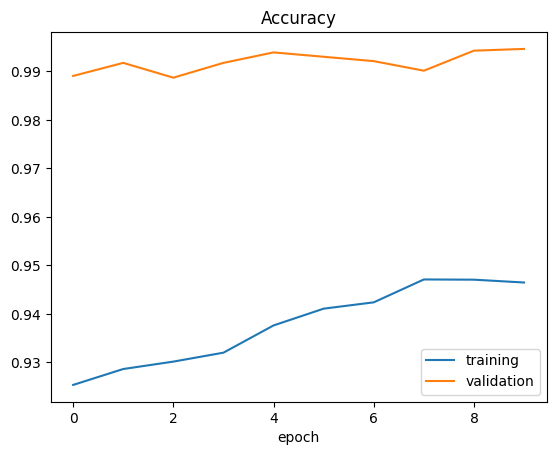

Test Score: 0.018788298591971397
Test Accuracy 0.9948275685310364


In [51]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()

score= model.evaluate(X_test, y_test, verbose = 0)
print("Test Score:", score[0])
print("Test Accuracy", score[1])


# **Save Model**

In [55]:
model.save("Trained traffic sign detection model.h5")


In [ ]:
frameWidth= 640
frameHeight = 480
brightness = 180
threshold = 0.75
font = cv2.FONT_HERSHEY_SIMPLEX


cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)

model=load_model("/content/Trained traffic sign detection model.h5")

def preprocessing(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img =cv2.equalizeHist(img)
    img = grayscale(img)
    img = equalize(img)
    img = img/255
return img


def getClassName(classNo):
    if   classNo == 0: return 'Speed Limit 20 km/h'
    elif classNo == 1: return 'Speed Limit 30 km/h'
    elif classNo == 2: return 'Speed Limit 50 km/h'
    elif classNo == 3: return 'Speed Limit 60 km/h'
    elif classNo == 4: return 'Speed Limit 70 km/h'
    elif classNo == 5: return 'Speed Limit 80 km/h'
    elif classNo == 6: return 'End of Speed Limit 80 km/h'
    elif classNo == 7: return 'Speed Limit 100 km/h'
    elif classNo == 8: return 'Speed Limit 120 km/h'
    elif classNo == 9: return 'No passing'
    elif classNo == 10: return 'No passing for vechiles over 3.5 metric tons'
    elif classNo == 11: return 'Right-of-way at the next intersection'
    elif classNo == 12: return 'Priority road'
    elif classNo == 13: return 'Yield'
    elif classNo == 14: return 'Stop'
    elif classNo == 15: return 'No vechiles'
    elif classNo == 16: return 'Vechiles over 3.5 metric tons prohibited'
    elif classNo == 17: return 'No entry'
    elif classNo == 18: return 'General caution'
    elif classNo == 19: return 'Dangerous curve to the left'
    elif classNo == 20: return 'Dangerous curve to the right'
    elif classNo == 21: return 'Double curve'
    elif classNo == 22: return 'Bumpy road'
    elif classNo == 23: return 'Slippery road'
    elif classNo == 24: return 'Road narrows on the right'
    elif classNo == 25: return 'Road work'
    elif classNo == 26: return 'Traffic signals'
    elif classNo == 27: return 'Pedestrians'
    elif classNo == 28: return 'Children crossing'
    elif classNo == 29: return 'Bicycles crossing'
    elif classNo == 30: return 'Beware of ice/snow'
    elif classNo == 31: return 'Wild animals crossing'
    elif classNo == 32: return 'End of all speed and passing limits'
    elif classNo == 33: return 'Turn right ahead'
    elif classNo == 34: return 'Turn left ahead'
    elif classNo == 35: return 'Ahead only'
    elif classNo == 36: return 'Go straight or right'
    elif classNo == 37: return 'Go straight or left'
    elif classNo == 38: return 'Keep right'
    elif classNo == 39: return 'Keep left'
    elif classNo == 40: return 'Roundabout mandatory'
    elif classNo == 41: return 'End of no passing'
    elif classNo == 42: return 'End of no passing by vechiles over 3.5 metric tons'

while True:

    success, imgOrignal = cap.read()


    img = np.asarray(imgOrignal)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)

    cv2.imshow("Processed Image", img)
    img = img.reshape(1, 32, 32, 1)
    cv2.putText(imgOrignal, "CLASS: " , (20, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(imgOrignal, "PROBABILITY: ", (20, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)


    predictions = model.predict(img)
    classIndex = model.predict_classes(img)
    probabilityValue =np.argmax(predictions)


    cv2.putText(imgOrignal,str(classIndex)+" "+str(getClassName(classIndex)), (120, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(imgOrignal, str(round(probabilityValue*100,2) )+"%", (180, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.imshow("Result", imgOrignal)

    if cv2.waitKey(1) & 0xFF == ord('q'):
      break
